In [4]:
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from joblib import load

In [5]:
if os.getcwd().split("\\")[-2] == "modeling":
    os.chdir(os.path.join(os.getcwd(), "..", ".."))

import problem

In [6]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

Basic Ridge

In [7]:
date_encoder = FunctionTransformer(problem._encode_dates)
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x00000171A5271160>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

In [8]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.80
Test set, RMSE=0.73


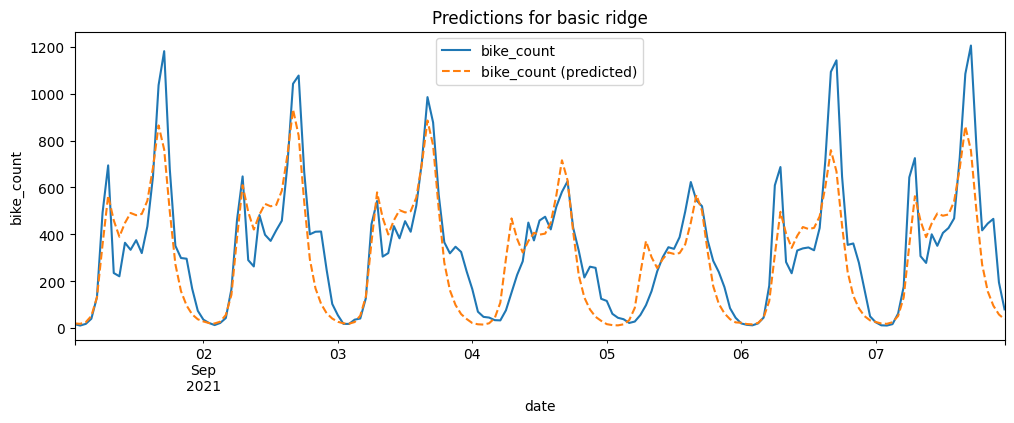

In [9]:
problem.week_plot(X_test, y_pred_test, y_test, "basic ridge")

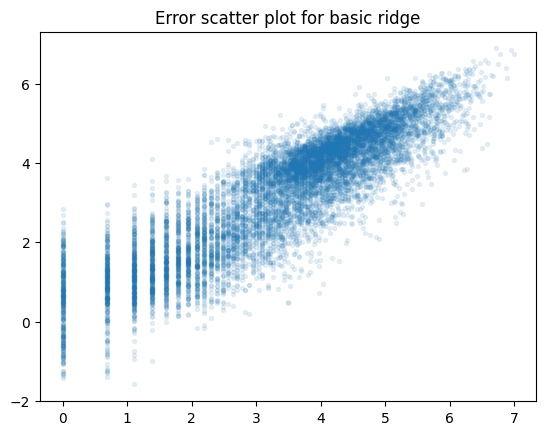

In [10]:
problem.error_plot(y_pred_test, y_test, "basic ridge")

### Ridge including additional data variables

In [11]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.to_list()

add_date_encoder = FunctionTransformer(problem._additional_date_variables)
add_date_cols = ["season"]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("add_date", OneHotEncoder(handle_unknown="ignore"), add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, add_date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _encode_dates at 0x00000171A5271160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _additional_date_variables at 0x00000171A52711F0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('add_date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

In [12]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.80
Test set, RMSE=0.72


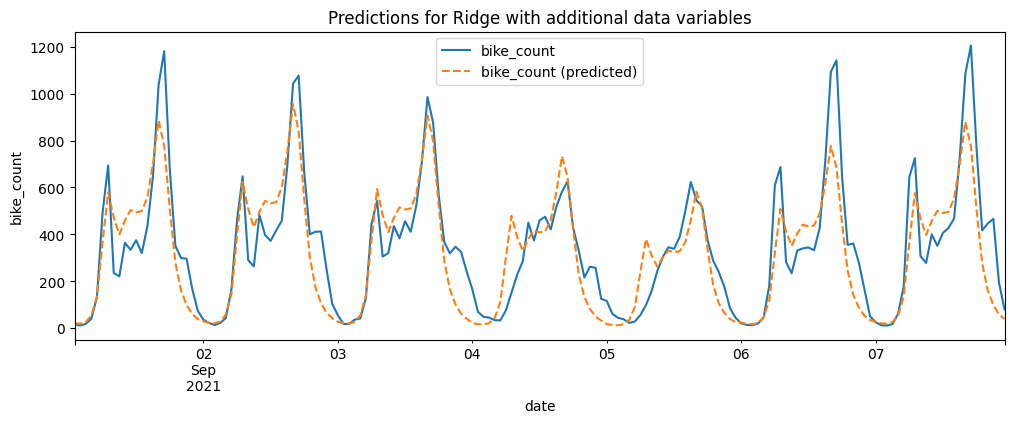

In [13]:
problem.week_plot(X_test, y_pred_test, y_test, "Ridge with additional data variables")

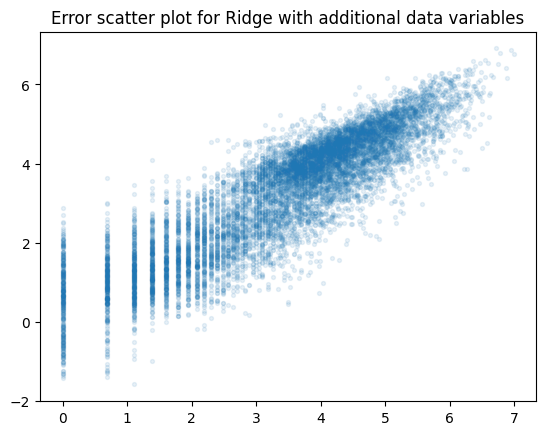

In [14]:
problem.error_plot(y_pred_test, y_test, "Ridge with additional data variables")

### Ridge including aditional variables and weather data

In [15]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(problem._additional_date_variables)
add_date_cols = ["season"]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("add_date", OneHotEncoder(handle_unknown="ignore"), add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x00000171A5271280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x00000171A5271160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x00000171A52711F0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('add_date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('ridge', Ridge())])

In [16]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.80
Test set, RMSE=0.72


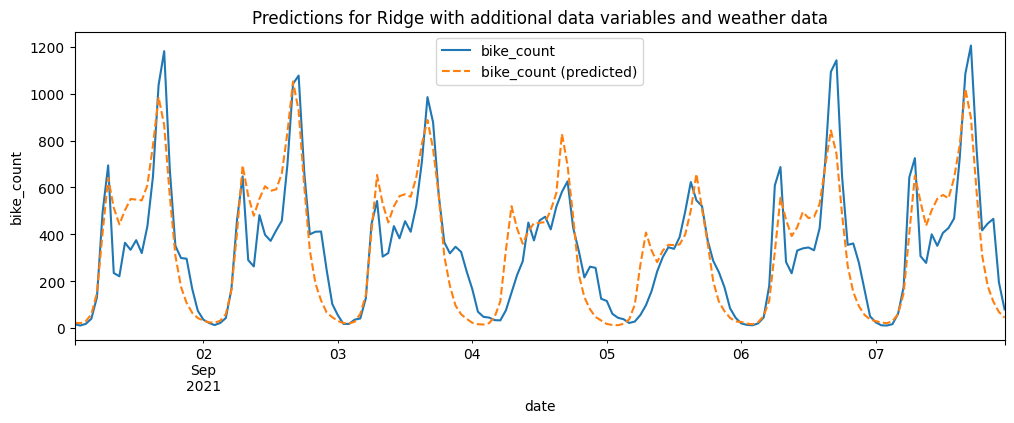

In [17]:
problem.week_plot(
    X_test, y_pred_test, y_test, "Ridge with additional data variables and weather data"
)

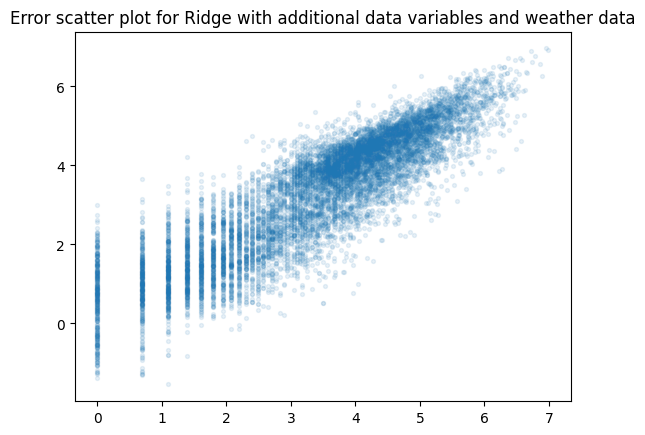

In [18]:
problem.error_plot(
    y_pred_test, y_test, "Ridge with additional data variables and weather data"
)

### Tuned ridge with additional variables and weather data

In [19]:
import pandas as pd
cv_results = pd.read_csv("./modeling/linear_models/results_tuning/20221118_0218_tuning_ridge_cv_results.csv")

In [20]:
cv_results.mean_test_score.min()

-0.8898146971233756

In [29]:
tuning_ridge = load("modeling/linear_models/results_tuning/20221118_0218_tuning_ridge_best_estimator.pkl")

In [30]:
tuning_ridge

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x00000171A5271280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x00000171A5271160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x00000171A52711F0>,...
                                     kw_args={'cols': ['counter_id', 'site_id',
                                                       'counter_installation_date',
                                                       'counter_technical_id']})),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('ridge', Ridge(alpha=0.88))])

### Lasso including additional data variables and weather data

In [23]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(problem._additional_date_variables)
add_date_cols = ["season"]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("add_date", OneHotEncoder(handle_unknown="ignore"), add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Lasso()

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x00000171A5271280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x00000171A5271160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x00000171A52711F0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('add_date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('lasso', Lasso())])

In [24]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=1.68
Test set, RMSE=1.49


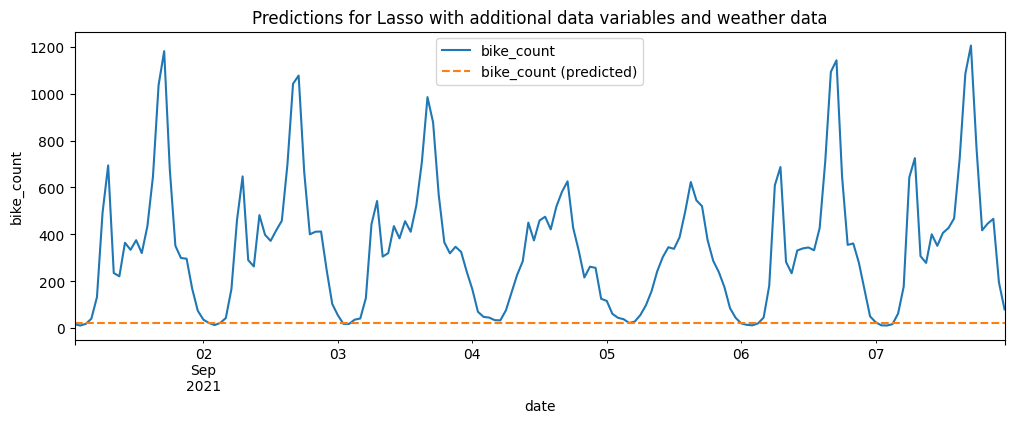

In [25]:
problem.week_plot(
    X_test, y_pred_test, y_test, "Lasso with additional data variables and weather data"
)

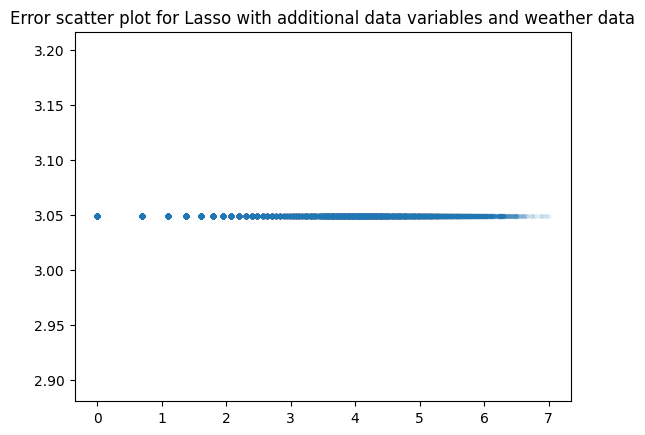

In [26]:
problem.error_plot(
    y_pred_test, y_test, "Lasso with additional data variables and weather data"
)

In [31]:
tuning_lasso = load("modeling/linear_models/results_tuning/20221117_1736_tuning_lasso_best_estimator.pkl")

In [32]:
tuning_lasso

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x00000171A5271280>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x00000171A5271160>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x00000171A52711F0>,...
                                     kw_args={'cols': ['counter_id', 'site_id',
                                                       'counter_installation_date',
                                                       'counter_technical_id']})),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('lasso', Lasso(alpha=0.01))])